# Plot full record of Mauna Loa in-situ data

### Load in Scripps CO2 Program Github Repository

In [316]:
import os
os.chdir('/content')
CODE_DIR = 'scrippsco2_notebooks'

In [317]:
!git clone https://github.com/lmerchant/scrippsco2_notebooks.git $CODE_DIR
%cd $CODE_DIR

fatal: destination path 'scrippsco2_notebooks' already exists and is not an empty directory.
/content/scrippsco2_notebooks


In [318]:
# get modifications made on the repo
!git pull origin main

From https://github.com/lmerchant/scrippsco2_notebooks
 * branch            main       -> FETCH_HEAD
Already up to date.


In [319]:
%matplotlib inline
import requests
from google.colab import files
import pandas as pd
import numpy as np
import pathlib
from datetime import datetime, date
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import ticker
from matplotlib import font_manager
from matplotlib import rc,rcParams
from IPython.display import Javascript, display
from ipywidgets import widgets

## Load in plotting functions

In [320]:
from utils import get_dates, configure_plots

### Set directories and file names for data,  plot, and logo

In [321]:
insitu_data_dir = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/'

plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

monthly_mlo = 'monthly/monthly_in_situ_co2_mlo.csv'
data_file = f"{insitu_data_dir}/{monthly_mlo}" 

pdf_file = plot_dir / 'mlo_record.pdf'
png_file = plot_dir / 'mlo_record.png'

logo_dir = './images'
logo_file  = pathlib.Path(logo_dir) /  'sio_logo.png'

### Get today's date

In [322]:
todays_date_moyr, todays_date_modyyr, today_decimal, todays_year = get_dates.get_todays_date()

### Set plot limits and text

In [323]:
xmin = 1957
xmax = todays_year + 2

ymin = 310
ymax = 425

In [324]:
xlabel = 'Year'
ylabel = '$\mathregular{CO_2}$ Concentration (ppm)'

title1 = 'Mauna Loa Observatory, Hawaii'
title2 = 'Monthly Average Carbon Dioxide Concentration'
title3 = f'Data from Scripps CO$_2$ Program     Last updated {todays_date_moyr}'

## Load in Data and process

### Fix bad security certificate for scrippsco2.ucsd.edu

In [325]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [326]:
df = pd.read_csv(data_file,sep=',',comment='"')
df.head()

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,03,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44


### Remove next two rows containing header information and change to numeric vals

In [327]:
df = df.iloc[2:]
df = df.apply(pd.to_numeric)

### Rename column names to replace duplicate names

In [328]:
col_mapping ={df.columns[0]:'year', df.columns[1]: 'month', df.columns[2]: 'excel_date', 
              df.columns[3]: 'dec_date', df.columns[4]: 'co2', df.columns[5]: 'co2_seasonal',
              df.columns[6]: 'co2_fit', df.columns[7]: 'co2_seasonal_fit', 
              df.columns[8]:'co2_filled', df.columns[9]: 'co2_seasonal_filled'}
df = df.rename(columns=col_mapping)
df.head()

,year,month,excel_date,dec_date,co2,co2_seasonal,co2_fit,co2_seasonal_fit,co2_filled,co2_seasonal_filled
2,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,3,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44
5,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16
6,1958,5,21320,1958.3699,317.51,314.71,317.87,315.07,317.51,314.71


### Break into 2 dataframes. One for CO2 and one for the CO2 spline
The decimal date is the midpoint of each month

In [329]:
df_co2 = df[['dec_date', 'co2']].copy()
df_co2_spline = df[['dec_date', 'co2_fit']].copy()

### Remove CO2 rows and CO2 spline rows with fill values -99.99

In [330]:
df_co2 = df_co2[df_co2['co2'] != -99.99]
df_co2_spline = df_co2_spline[df_co2_spline['co2_fit'] != -99.99]

### Convert to numpy arrays for plotting

In [331]:
date_co2 = df_co2['dec_date'].to_numpy()
co2 = df_co2['co2'].to_numpy()
date_co2_spline = df_co2_spline['dec_date'].to_numpy()
co2_spline = df_co2_spline['co2_fit'].to_numpy()

# Enter plotting functions

### Get todays date

In [332]:
def get_todays_date():

    # Get variations of todays date

    def dt_to_dec(dt):
        """Convert a datetime to decimal year."""
        year_start = datetime(dt.year, 1, 1)
        year_end = year_start.replace(year=dt.year+1)
        return dt.year + (dt - year_start) / (year_end - year_start)

    today = date.today()
    today_with_time = datetime(
        year=today.year, month=today.month, day=today.day)

    today_decimal = dt_to_dec(today_with_time)

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, today_decimal, todays_year

### Get archive date from file

In [333]:
def get_file_archive_date(data_file):

    # Sample archive line from file
    # " Baseline data in this file through 01-Jul-2021 from archive dated 02-Jul-2021 09:04:47    "

    pattern_archive = re.compile("archive")
    pattern_archive_date = re.compile(r'archive dated (\d\d-\w{3}-\d\d\d\d)')

    for line in open(data_file):
        for match in re.finditer(pattern_archive, line):
            m = pattern_archive_date.search(line)
            archive_date = m.group(1)
            archive_datetime = datetime.strptime(archive_date, '%d-%b-%Y')
            # Reformat to Month name Month day, Month year
            month = archive_datetime.strftime("%B")
            archive_date = f"{month} {archive_datetime.day}, {archive_datetime.year}"
            break

    return archive_date

### Set plot limits

In [334]:
todays_date_moyr, todays_date_modyyr, today_decimal, todays_year = get_todays_date()

xmin = 1957
xmax = todays_year + 2

ymin = 310
ymax = 425

### Set plot labels

In [335]:
xlabel = 'Year'
ylabel = '$\mathregular{CO_2}$ Concentration (ppm)'

ax.set_xlabel(xlabel, fontsize=21, fontweight=400, labelpad=8)
ax.set_ylabel(ylabel, fontsize=21, fontweight=400, labelpad=8)

Text(3.200000000000003, 0.5, '$\\mathregular{CO_2}$ Concentration (ppm)')

### Set plot titles

In [336]:
def add_3_plot_titles(fig, ax, title1, title2, title3):

    # Allow room at top for the 3 titles
    fig.subplots_adjust(top=0.85)

    # Set font properties
    rcParams.update({
      'font.family':'sans-serif',
      'font.weight':'bold',
      'font.sans-serif':['Liberation Sans', 'DejaVu Sans']
    })

    # position titles above plot
    ax.annotate(title1, xy=(0, 1.15), xycoords='axes fraction', fontsize=21,
                horizontalalignment='left', verticalalignment='top')
    ax.annotate(title2, xy=(0, 1.095), xycoords='axes fraction', fontsize=21,
                horizontalalignment='left', verticalalignment='top')
    ax.annotate(title3, xy=(0, 1.04), xycoords='axes fraction', fontsize=12, fontweight='normal',
                horizontalalignment='left', verticalalignment='top')

### Set plot ticks and axis properties

In [337]:
def set_axis_tick_props(fig, ax, xmin, xmax, ymin, ymax):

    # activate latex text rendering
    rc('axes', linewidth=1)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Set tick labels font
    rcParams.update({
      'font.family':'sans-serif',
      'font.weight':'bold',
      'font.sans-serif':['Liberation Sans', 'DejaVu Sans']
    })
        
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)

    ax.tick_params(which='major', direction='in', length=9, width=1)

    xaxis_tick_spacing = 5
    ax.xaxis.set_major_locator(ticker.MultipleLocator(xaxis_tick_spacing))

    yaxis_tick_spacing = 5
    ax.yaxis.set_major_locator(ticker.MultipleLocator(yaxis_tick_spacing))

    # Display every other y major tick label
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    ax.tick_params(which='minor', direction='in', length=4)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

In [338]:
 !fc-list

/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf: Liberation Sans Narrow:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf: Liberation Sans:style=Regular
/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf: Liberation Mono:style=Bold Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf: Liberation Serif:style=Italic
/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf: Liberation Mono:style=Bold
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf: Liberation Sans Narrow:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf: Liberation Serif:style=Bold
/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf: Liberation Mono:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf: Liberation Sans:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf: Liberation Serif:style=Bold Italic
/usr/share/fonts/truet

### Get SIO logo

In [339]:
def add_sio_logo(fig, logo_file):

    # Add SIO logo to plot

    logo = mpimg.imread(logo_file)

    newax = fig.add_axes([0.73, 0.18, 0.2, 0.2], anchor='SE', zorder=1)
    plt.imshow(logo)
    plt.axis('off')

In [340]:
    rcParams['font.family']
    families  = font_manager.findfont(font_manager.FontProperties(family=['sans-serif']))
    families

'/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf'

### Save plot

In [341]:
def save_plot_pdf_png(fig, pdf_file, png_file):

    # Save plot as  pdf and png for scrippsco2 website

    # For pdf
    width_in = 11
    height_in = 8.5
    fig.set_size_inches(width_in, height_in)

    plt.subplots_adjust(left=0.109, right=0.95, top=0.85, bottom=0.15)

    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, pad_inches=0)

    # For png
    width_px = 1200
    height_px = (height_in/width_in) * width_px

    png_dpi = 100
    fig.set_size_inches(width_px/png_dpi, height_px/png_dpi)

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, pad_inches=0)

## Create Plot

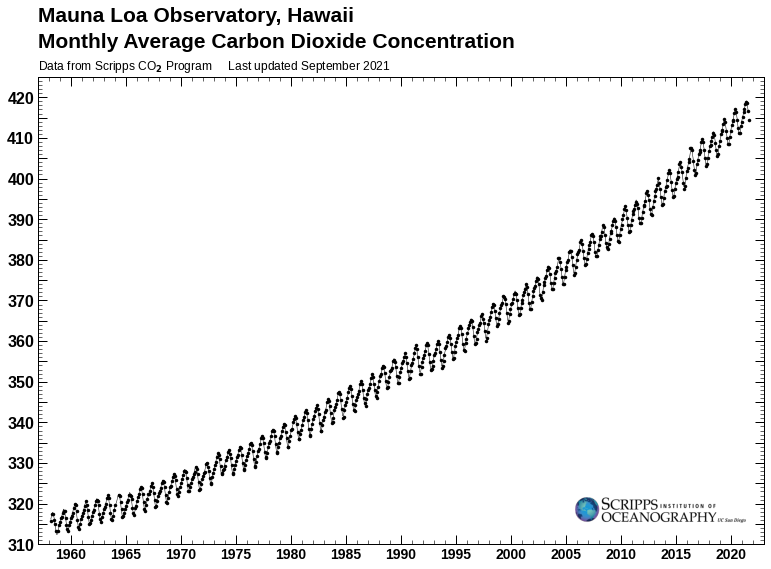

In [342]:
fig = plt.figure()
ax = fig.add_subplot()

# -------------
# Plot the data
# -------------

ax.plot(date_co2, co2, 'o', color='black',
         markersize=3.5, linewidth=1,
         markerfacecolor='black', markeredgecolor='black', markeredgewidth=0)

ax.plot(date_co2_spline, co2_spline, '-', color='black', linewidth=0.5)


# -------------------
# Set plot properties
# -------------------

set_axis_tick_props(fig, ax, xmin, xmax, ymin, ymax)

# ---------------
# Add plot titles
# ---------------

add_3_plot_titles(fig, ax, title1, title2, title3)

# --------------------
# Add SIO logo to plot
# --------------------
add_sio_logo(fig, logo_file)

# ---------------------
# Save plot for website
# ---------------------
fig = plt.gcf()

save_plot_pdf_png(fig, pdf_file, png_file)

plt.show()

## Download Plots (pdf & png)

In [343]:
# from IPython.display import Javascript, display
# from ipywidgets import widgets

def download_files(ev):
    #display(Javascript('IPython.notebook.execute_cells_below()'))
    files.download(pdf_file)

button = widgets.Button(description='Download Files', button_style='primary')
button.on_click(download_files)
display(button)

Button(button_style='primary', description='Download Files', style=ButtonStyle())

In [344]:
!ls plots

mlo_record.pdf	mlo_record.png
